In [16]:
import csv
import os
import re
import tensorflow as tf

from object_detection import evaluator
from object_detection.core import standard_fields
from object_detection.metrics import tf_example_parser
from object_detection.utils import config_util
from object_detection.utils import label_map_util

import numpy as np
# flags = tf.app.flags
# tf.logging.set_verbosity(tf.logging.INFO)

# flags.DEFINE_string('eval_dir', None, 'Directory to write eval summaries to.')
# flags.DEFINE_string('eval_config_path', None,
#                     'Path to an eval_pb2.EvalConfig config file.')
# flags.DEFINE_string('input_config_path', None,
#                     'Path to an eval_pb2.InputConfig config file.')

# FLAGS = flags.FLAGS
import cv2
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
%matplotlib inline



In [107]:
PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')
NUM_CLASSES = 547
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [2]:
def _generate_filenames(filenames):
  result = []
  for filename in filenames:
    result += _generate_sharded_filenames(filename)
  return result

In [3]:
def _generate_sharded_filenames(filename):
  m = re.search(r'@(\d{1,})', filename)
  if m:
    num_shards = int(m.group(1))
    return [
        re.sub(r'@(\d{1,})', '-%.5d-of-%.5d' % (i, num_shards), filename)
        for i in range(num_shards)
    ]
  else:
    return [filename]

In [4]:
  # new format, train_out_547_1GPU1batch_lrPet, all test data 
  required_flags = ['input_config_path', 'eval_config_path', 'eval_dir']
#   for flag_name in required_flags:
#     if not getattr(FLAGS, flag_name):
#       raise ValueError('Flag --{} is required'.format(flag_name))

  configs = config_util.get_configs_from_multiple_files(
      eval_input_config_path='/root/oid_bbox_trainable_label_map_add2_test_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_annotations-human-bbox/test_input_config.pbtxt',
      eval_config_path='/root/oid_bbox_trainable_label_map_add2_test_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_annotations-human-bbox/test_eval_config.pbtxt')

  eval_config = configs['eval_config']
  input_config = configs['eval_input_config']

In [5]:
  if input_config.WhichOneof('input_reader') == 'tf_record_input_reader':
    input_paths = input_config.tf_record_input_reader.input_path

    label_map = label_map_util.load_labelmap(input_config.label_map_path)
    max_num_classes = max([item.id for item in label_map.item])
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes)

    object_detection_evaluators = evaluator.get_evaluators(
        eval_config, categories)
    # Support a single evaluator
    object_detection_evaluator = object_detection_evaluators[0]

    skipped_images = 0
    processed_images = 0

In [7]:
    infer_dict = {}
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
#         print(decoded_dict)
        if True:
#             decoded_dict['detection_classes'][0] = 15
            if decoded_dict:
                infer_dict[decoded_dict[standard_fields.DetectionResultFields.key]]= \
                    decoded_dict
#               object_detection_evaluator.add_single_ground_truth_image_info(
#                   decoded_dict[standard_fields.DetectionResultFields.key],
#                   decoded_dict)
#               object_detection_evaluator.add_single_detected_image_info(
#                   decoded_dict[standard_fields.DetectionResultFields.key],
#                   decoded_dict)
            else:
              skipped_images += 1
              tf.logging.info('Skipped images: {0}'.format(skipped_images))
#             break
          
        else:
            continue
#         if processed_images == 10:
#           break
print(processed_images)




INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_test_annotations-human-bbox_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 10 images...
INFO:tensorflow:Processed 1010 images...
INFO:tensorflow:Processed 2010 images...
INFO:tensorflow:Processed 3010 images...
INFO:tensorflow:Processed 4010 images...
INFO:tensorflow:Processed 5010 images...
INFO:tensorflow:Processed 6010 images...
INFO:tensorflow:Processed 7010 images...
INFO:tensorflow:Processed 8010 images...
INFO:tensorflow:Processed 9010 images...
INFO:tensorflow:Processed 10010 images...
INFO:tensorflow:Processed 11010 images...
INFO:tensorflow:Processed 12010 images...
INFO:tensorflow:Processed 13010 images...
INFO:tensorflow:Processed 14010 images...
INFO:tensorflow:Processed 15010 images...
INFO:tensorflow:Processed 16010 images...
INFO:tensorflow:Processed 17010 images...
INFO:tensorflow:Processed 18010 images...
INFO:tensorflow:Processed 19010 i

In [8]:
## th 0 - 1.0
# threshold = 0.2
thresholds = np.linspace(0.0, 1.0, num=11)
precision_per_th = []
recall_per_th = []
fscore_per_th = []

for idx, threshold in enumerate(thresholds):

    gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0


    for image, decoded_dict in infer_dict.items():
        gt_classes_set = set()
        for groundtruth_classes in decoded_dict['groundtruth_classes']:
            gt_classes_set.add(groundtruth_classes)
        for groundtruth_classes in gt_classes_set:
            gt_num_per_class[groundtruth_classes] += 1


    for image, decoded_dict in infer_dict.items():
        index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
        detection_classes_set = set()
        for detection_classes in decoded_dict['detection_classes'][index_threshold]:
            detection_classes_set.add(detection_classes)
        for detection_classes in detection_classes_set:
            if detection_classes in decoded_dict['groundtruth_classes']:
                tp_num_per_class[detection_classes] += 1
            else:
                fp_num_per_class[detection_classes] += 1
            det_num_per_class[detection_classes] += 1


    precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

    for idx, det in enumerate(det_num_per_class):
        if det == 0:
            precision_per_class[idx] = np.nan
        else:
            precision_per_class[idx] = tp_num_per_class[idx] / det

    for idx, det in enumerate(gt_num_per_class):
        if det == 0:
            recall_per_class[idx] = np.nan
        else:
            recall_per_class[idx] = tp_num_per_class[idx] / det

    fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    for idx, fscore in enumerate(fscore_per_class):
        if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
            fscore_per_class[idx] = 0
        else :
            fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]

    precision_per_th.append(np.nanmean(precision_per_class))
    recall_per_th.append(np.nanmean(recall_per_class))
    fscore_per_th.append(np.nanmean(fscore_per_class))
    


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


In [9]:
precision_per_th

[0.050069938167170314,
 0.24939399208971888,
 0.3290305762488304,
 0.3879310183092538,
 0.4414531362512061,
 0.49039468019181165,
 0.5427926885556201,
 0.5907752607497697,
 0.6539410167997285,
 0.7506911335151922,
 nan]

In [10]:
precision_per_th[-1] = 1

In [11]:
recall_per_th

[0.978271374678879,
 0.8751691580054135,
 0.8103461352093065,
 0.7532346940588762,
 0.6997962076205048,
 0.6456939910486823,
 0.5899710846434647,
 0.5258750701528474,
 0.4528139539864711,
 0.3509684569650623,
 0.0]

In [12]:
fscore_per_th

[0.0875372466334172,
 0.35338289488935015,
 0.4253990563594993,
 0.46516131746048167,
 0.4874327103572455,
 0.49801489231907986,
 0.5021881283293139,
 0.49420613076846437,
 0.48171222568401517,
 0.4606441715834243,
 nan]

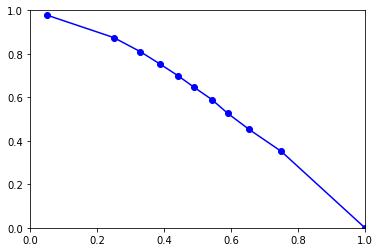

In [34]:
x=precision_per_th
y=recall_per_th
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
# IMAGE_SIZE = (12, 8)
# plt.figure(figsize=IMAGE_SIZE)

# plt.figure(figsize=IMAGE_SIZE, dpi=80)

plt.plot(x, y, '-ob');
plt.savefig('/root/PR_100test.png', transparent=False, dpi = 300)



In [35]:
from sklearn.metrics import roc_curve, auc

auc(x,y)

0.5423760011211842

0.5919019638252115


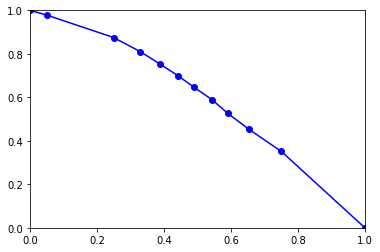

In [59]:
from sklearn.metrics import roc_curve, auc
xx = x[:]
yy = y[:]
xx.insert(0,0)
yy.insert(0,1)
print(auc(xx,yy))

plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
plt.plot(xx, yy, '-ob');
plt.savefig('/root/PR_100test2.png', transparent=False, dpi = 300)

# simcloud -c mr2 job scp -r   $DID:~/PR_100test2.png ~/openimage


0.5919019638252115


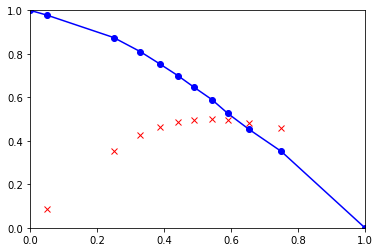

In [66]:
from sklearn.metrics import roc_curve, auc
xx = x[:]
yy = y[:]
xx.insert(0,0)
yy.insert(0,1)
print(auc(xx,yy))

plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
plt.plot(xx, yy, '-ob', x, fscore_per_th,'xr');
# plt.savefig('/root/PR_100test2.png', transparent=False, dpi = 300)

# simcloud -c mr2 job scp -r   $DID:~/PR_100test2.png ~/openimage



0.5919019638252115


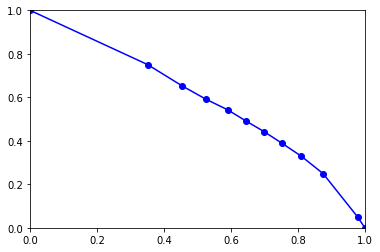

In [72]:
from sklearn.metrics import roc_curve, auc
xx = recall_per_th[:]
yy = precision_per_th[:]
xx.insert(0,1)
yy.insert(0,0)
print(auc(xx,yy))

plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
plt.plot(xx, yy, '-ob');
plt.savefig('/root/PR_100test2.png', transparent=False, dpi = 300)

# simcloud -c mr2 job scp -r   $DID:~/PR_100test2.png ~/openimage




0.5919019638252115


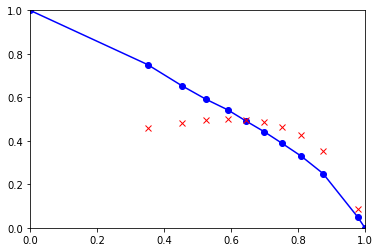

In [74]:
from sklearn.metrics import roc_curve, auc
xx = recall_per_th[:]
yy = precision_per_th[:]
xx.insert(0,1)
yy.insert(0,0)
print(auc(xx,yy))

plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
plt.plot(xx, yy, '-ob', recall_per_th, fscore_per_th,'xr');

plt.savefig('/root/PR_100test2_fscore.png', transparent=False, dpi = 300)

# simcloud -c mr2 job scp -r   $DID:~/PR_100test2.png ~/openimage



In [75]:
print(recall_per_th)
print(precision_per_th)
print(fscore_per_th)

[0.978271374678879, 0.8751691580054135, 0.8103461352093065, 0.7532346940588762, 0.6997962076205048, 0.6456939910486823, 0.5899710846434647, 0.5258750701528474, 0.4528139539864711, 0.3509684569650623, 0.0]
[0.050069938167170314, 0.24939399208971888, 0.3290305762488304, 0.3879310183092538, 0.4414531362512061, 0.49039468019181165, 0.5427926885556201, 0.5907752607497697, 0.6539410167997285, 0.7506911335151922, 1]
[0.0875372466334172, 0.35338289488935015, 0.4253990563594993, 0.46516131746048167, 0.4874327103572455, 0.49801489231907986, 0.5021881283293139, 0.49420613076846437, 0.48171222568401517, 0.4606441715834243, nan]


In [93]:
    threshold = 0.6
    gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0


    for image, decoded_dict in infer_dict.items():
        gt_classes_set = set()
        for groundtruth_classes in decoded_dict['groundtruth_classes']:
            gt_classes_set.add(groundtruth_classes)
        for groundtruth_classes in gt_classes_set:
            gt_num_per_class[groundtruth_classes] += 1


    for image, decoded_dict in infer_dict.items():
        index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
        detection_classes_set = set()
        for detection_classes in decoded_dict['detection_classes'][index_threshold]:
            detection_classes_set.add(detection_classes)
        for detection_classes in detection_classes_set:
            if detection_classes in decoded_dict['groundtruth_classes']:
                tp_num_per_class[detection_classes] += 1
            else:
                fp_num_per_class[detection_classes] += 1
            det_num_per_class[detection_classes] += 1


    precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

    for idx, det in enumerate(det_num_per_class):
        if det == 0:
            precision_per_class[idx] = np.nan
        else:
            precision_per_class[idx] = tp_num_per_class[idx] / det

    for idx, det in enumerate(gt_num_per_class):
        if det == 0:
            recall_per_class[idx] = np.nan
        else:
            recall_per_class[idx] = tp_num_per_class[idx] / det

    fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    for idx, fscore in enumerate(fscore_per_class):
        if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
            fscore_per_class[idx] = 0
        else :
            fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]

#     precision_per_th.append(np.nanmean(precision_per_class))
#     recall_per_th.append(np.nanmean(recall_per_class))
#     fscore_per_th.append(np.nanmean(fscore_per_class))
    



In [113]:
det_num_per_class == tp_num_per_class + fp_num_per_class # all true!

In [94]:
precision_per_class

array([       nan, 0.87196468, 0.66016713, 0.78445122, 0.79414975,
       0.80162675, 0.73479853, 0.79647218, 0.5       , 0.83129856,
       0.55984556, 0.72766416, 0.84732824, 0.13461538, 0.97136733,
       0.86824769, 0.79620853, 0.96003308, 0.31707317, 0.64402174,
       0.56312057, 0.75786925, 0.66      , 0.62941176, 0.70992366,
       0.70557491, 0.3362069 , 0.93177738, 0.        , 0.72110286,
       0.9857393 , 0.12681638,        nan, 0.59459459, 0.4       ,
       0.66666667, 0.88333333, 0.98830409, 0.74011299, 0.66666667,
       0.96547884, 0.14202899, 0.71196755, 0.86324786, 0.55648536,
              nan, 0.6557377 ,        nan, 0.67466667, 0.65551839,
       0.37777778, 0.655     , 0.40108401, 0.8       , 0.90942029,
       0.99115044, 0.43181818, 0.        , 0.50902527, 0.79075426,
       0.52808989, 0.5625    , 0.92741935, 0.5       , 0.97142857,
       0.15433404, 0.97102273, 0.84      , 0.48880597, 0.3442623 ,
       0.97142857, 0.7628866 , 0.62815126, 0.325     , 0.82258

In [120]:
select_idx = np.where(precision_per_class <= 0.49)
print(select_idx)
print(len(select_idx[0]))
set_precision = set(select_idx[0])

(array([ 13,  18,  26,  28,  31,  34,  41,  50,  52,  56,  57,  65,  68,
        69,  73,  77,  83,  85,  92,  94,  95,  96,  97,  99, 101, 102,
       103, 104, 107, 114, 116, 117, 123, 126, 127, 128, 129, 132, 133,
       135, 138, 143, 144, 145, 146, 149, 151, 152, 153, 154, 155, 156,
       159, 162, 165, 168, 170, 172, 178, 180, 181, 183, 187, 188, 190,
       201, 203, 204, 206, 212, 214, 215, 218, 219, 223, 224, 230, 233,
       235, 239, 242, 243, 246, 252, 257, 259, 263, 268, 273, 275, 276,
       278, 281, 282, 283, 284, 289, 290, 292, 301, 302, 303, 305, 310,
       314, 316, 319, 321, 322, 324, 325, 327, 329, 330, 336, 338, 353,
       354, 360, 361, 365, 371, 373, 374, 376, 379, 380, 383, 384, 387,
       394, 395, 403, 406, 407, 412, 414, 415, 416, 419, 420, 421, 424,
       427, 430, 431, 433, 437, 438, 439, 440, 442, 444, 445, 446, 452,
       454, 455, 458, 460, 461, 462, 465, 466, 467, 469, 473, 474, 475,
       476, 477, 482, 485, 486, 488, 490, 491, 492, 495, 497, 5

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


In [121]:
recall_per_class

array([           nan, 8.13678031e-02, 1.71714244e-02, 3.05872563e-01,
       4.29972816e-01, 2.66206483e-01, 2.26923077e-01, 2.00375491e-01,
       6.33312223e-04, 2.88076923e-01, 2.92044310e-02, 1.47856518e-01,
       2.30721264e-02, 1.01449275e-02, 8.65307236e-01, 1.21856509e-01,
       1.53089120e-02, 5.13792595e-01, 1.03420843e-02, 1.58740790e-01,
       6.07033639e-01, 2.43959470e-01, 1.97841727e-02, 8.59437751e-02,
       2.72727273e-01, 6.82967960e-01, 5.32423208e-02, 5.19779670e-01,
       0.00000000e+00, 5.93368237e-01, 8.19126819e-01, 1.97125257e-01,
       0.00000000e+00, 2.78873239e-01, 4.88997555e-03, 8.01603206e-03,
       2.91208791e-01, 2.91278869e-02, 3.09619475e-02, 2.01106083e-04,
       8.82892057e-01, 1.47147147e-01, 4.83471074e-01, 7.16312057e-01,
       6.04545455e-01, 0.00000000e+00, 6.29921260e-01, 0.00000000e+00,
       3.30287206e-01, 3.90438247e-01, 5.61056106e-02, 5.74561404e-01,
       4.82084691e-01, 4.11214953e-01, 8.17589577e-01, 3.03728814e-02,
      

In [126]:
select_idx = np.where(recall_per_class <= 0.49)
print(select_idx)
print(len(select_idx[0]))
set_recall = set(select_idx[0])

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  18,  19,  21,  22,  23,  24,  26,  28,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  41,  42,  45,  47,  48,  49,  50,
        52,  53,  55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  68,
        69,  70,  71,  72,  73,  74,  75,  77,  79,  80,  81,  82,  83,
        89,  92,  95,  96,  97,  98,  99, 100, 103, 104, 108, 113, 117,
       119, 121, 129, 131, 139, 141, 142, 145, 149, 151, 152, 155, 157,
       158, 159, 171, 172, 173, 177, 178, 181, 183, 185, 186, 187, 189,
       192, 203, 210, 216, 217, 218, 219, 223, 224, 227, 231, 233, 239,
       246, 247, 249, 252, 269, 271, 272, 273, 281, 285, 290, 294, 298,
       301, 302, 309, 314, 316, 333, 340, 342, 345, 346, 353, 355, 357,
       358, 382, 386, 392, 393, 394, 397, 405, 408, 409, 431, 432, 434,
       438, 447, 448, 453, 454, 459, 464, 479, 486, 488, 498, 505, 506,
       511, 512, 522, 523, 524, 530, 535, 536, 543]),)
178


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


In [127]:
union = set_recall.intersection(set_precision)
print(union)
print(len(union))
print([category_index[x]['name'] for x in union])

set([512, 129, 224, 522, 535, 273, 13, 301, 145, 18, 149, 151, 152, 281, 26, 155, 28, 31, 34, 41, 172, 178, 223, 431, 50, 52, 181, 438, 183, 56, 57, 314, 159, 316, 394, 65, 68, 69, 454, 353, 73, 187, 203, 77, 83, 218, 219, 92, 95, 96, 97, 99, 486, 536, 103, 104, 233, 530, 239, 488, 302, 117, 246, 524, 505, 252, 290])
67
[u'Personal care', u'Porch', u'Sandal', u'Serving tray', u'Bench', u'Baseball bat', u'Animal', u'Nightstand', u'Hiking equipment', u'Furniture', u'Coffee table', u'Marine mammal', u'Goose', u'Racket', u'Auto part', u'Home appliance', u'Sports equipment', u'Carnivore', u'Musical instrument', u'Watercraft', u'Kitchen appliance', u'Tool', u'Platter', u'Seat belt', u'Invertebrate', u'Poster', u'Canoe', u'Tiara', u'Scarf', u'Hat', u'Tableware', u'Foot', u'Luggage and bags', u'Wok', u'Bathroom cabinet', u'Aircraft', u'Jacket', u'Street light', u'Kitchen knife', u'Mechanical fan', u'Trousers', u'Clock', u'Skirt', u'Desk', u'Fast food', u'Bowl', u'Glove', u'Goggles', u'Shorts',

In [128]:
interset_select = (np.array(sorted(list(union))), )

In [130]:
# recall_per_class[interset_select] = np.nan

In [131]:
# precision_per_class[interset_select] = np.nan

In [132]:
np.nanmean(precision_per_class)

0.5816493627546684

In [134]:
np.nanmean(recall_per_class)

0.6429637792375303

In [135]:
## bbox_labels_600_hierarchy.json
import json

with open('/root/bbox_labels_600_hierarchy.json') as json_file:
    data = json.load(json_file)


In [150]:
idx = 1
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 3
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 7
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 21
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 12
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Person', 0.8719646799116998, 0.08136780306931712, 19418.0, 0.14884597268016958)
(u'Man', 0.7844512195121951, 0.30587256300523064, 8412.0, 0.44013000342114267)
(u'Woman', 0.7964721845318861, 0.20037549069807134, 5859.0, 0.3201963725623892)
(u'Boy', 0.7578692493946732, 0.24395946999220577, 1283.0, 0.36910377358490565)
(u'Girl', 0.8473282442748091, 0.02307212637705259, 4811.0, 0.044921084581141246)


In [142]:
19418-8412-5859-1283-4811

-947

In [196]:
    threshold = 0.5
    gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0


    for image, decoded_dict in infer_dict.items():
        gt_classes_set = set()
        for groundtruth_classes in decoded_dict['groundtruth_classes']:
            gt_classes_set.add(groundtruth_classes)
        for groundtruth_classes in gt_classes_set:
            gt_num_per_class[groundtruth_classes] += 1


    for image, decoded_dict in infer_dict.items():
        index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
        detection_classes_set = set()
        for detection_classes in decoded_dict['detection_classes'][index_threshold]:
            detection_classes_set.add(detection_classes)
            # add mens to person
            if detection_classes in [3, 7, 21, 12]:
                detection_classes_set.add(1)
        for detection_classes in detection_classes_set:
            if detection_classes in decoded_dict['groundtruth_classes']:
                tp_num_per_class[detection_classes] += 1
            else:
                fp_num_per_class[detection_classes] += 1
            det_num_per_class[detection_classes] += 1


    precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

    for idx, det in enumerate(det_num_per_class):
        if det == 0:
            precision_per_class[idx] = np.nan
        else:
            precision_per_class[idx] = tp_num_per_class[idx] / det

    for idx, det in enumerate(gt_num_per_class):
        if det == 0:
            recall_per_class[idx] = np.nan
        else:
            recall_per_class[idx] = tp_num_per_class[idx] / det

    fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    for idx, fscore in enumerate(fscore_per_class):
        if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
            fscore_per_class[idx] = 0
        else :
            fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]

#     precision_per_th.append(np.nanmean(precision_per_class))
#     recall_per_th.append(np.nanmean(recall_per_class))
#     fscore_per_th.append(np.nanmean(fscore_per_class))
    




In [180]:
idx = 1 # th 0.6
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 3
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 7
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 21
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 12
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Person', 0.5216332378223496, 0.18750643732619218, 19418.0, 0.2758542313811652)
(u'Man', 0.7844512195121951, 0.30587256300523064, 8412.0, 0.44013000342114267)
(u'Woman', 0.7964721845318861, 0.20037549069807134, 5859.0, 0.3201963725623892)
(u'Boy', 0.7578692493946732, 0.24395946999220577, 1283.0, 0.36910377358490565)
(u'Girl', 0.8473282442748091, 0.02307212637705259, 4811.0, 0.044921084581141246)


In [197]:
idx = 546 # th 0.5
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 547 
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Parking meter', 0.375, 1.0, 3.0, 0.5454545454545454)
(u'Coconut', 0.19117647058823528, 0.6190476190476191, 21.0, 0.29213483146067415)


In [195]:
idx = 546 # th 0.6
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 547 
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Parking meter', 0.375, 1.0, 3.0, 0.5454545454545454)
(u'Coconut', 0.3023255813953488, 0.6190476190476191, 21.0, 0.40625)


In [193]:
idx = 546 # th 0.8
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 547 
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Parking meter', 0.75, 1.0, 3.0, 0.8571428571428571)
(u'Coconut', 0.35714285714285715, 0.23809523809523808, 21.0, 0.2857142857142857)


In [191]:
idx = 546 # th 0.9
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])
idx = 547 
print(category_index[idx]['name'],precision_per_class[idx],recall_per_class[idx],gt_num_per_class[idx],fscore_per_class[idx])

(u'Parking meter', 1.0, 1.0, 3.0, 1.0)
(u'Coconut', 0.75, 0.14285714285714285, 21.0, 0.24000000000000002)


In [184]:
decoded_dict=infer_dict['e9ec2617897763cc']
select_idx = np.where(decoded_dict['detection_scores'] >= 0.1)


print([category_index[x]['name'] for x in decoded_dict['groundtruth_classes']])
print([category_index[x]['name'] for x in decoded_dict['detection_classes'][select_idx]])
print(decoded_dict['detection_scores'][select_idx])

#https://storage.googleapis.com/openimages/web/visualizer/index.html?set=valtest&type=detection&c=%2Fm%2F05r655&id=e9ec2617897763cc

[u'Dress', u'Dress', u'Person', u'Human body', u'Woman', u'Woman', u'Woman', u'Hair', u'Hair', u'Clothing', u'Hand', u'Hand']
[u'Woman', u'Dress', u'Face', u'Face', u'Woman', u'Face', u'Man', u'Face', u'Woman', u'Man', u'Clothing', u'Face', u'Face', u'Coat', u'Face', u'Clothing', u'Hair', u'Dress', u'Clothing', u'Suit', u'Man', u'Brassiere', u'Girl', u'Clothing', u'Hand', u'Face']
[0.796 0.767 0.68  0.57  0.53  0.441 0.395 0.388 0.383 0.382 0.335 0.277
 0.262 0.262 0.261 0.187 0.179 0.158 0.152 0.151 0.15  0.144 0.13  0.119
 0.108 0.104]


In [168]:
for item in data['Subcategory']:
    if len(item) > 1:
        print(item)

{u'Subcategory': [{u'LabelName': u'/m/0167gd'}, {u'LabelName': u'/m/01j51'}, {u'LabelName': u'/m/029b3'}, {u'LabelName': u'/m/02wmf'}, {u'LabelName': u'/m/02zt3'}, {u'LabelName': u'/m/0kmg4'}], u'LabelName': u'/m/0138tl'}
{u'Subcategory': [{u'LabelName': u'/m/0174k2'}, {u'LabelName': u'/m/01k6s3'}, {u'LabelName': u'/m/029bxz'}, {u'LabelName': u'/m/02pjr4'}, {u'LabelName': u'/m/02wv84t'}, {u'LabelName': u'/m/02x984l'}, {u'LabelName': u'/m/03qhv5'}, {u'LabelName': u'/m/03s_tn'}, {u'LabelName': u'/m/03wvsk'}, {u'LabelName': u'/m/040b_t'}, {u'LabelName': u'/m/04169hn'}, {u'LabelName': u'/m/04lvq_'}, {u'LabelName': u'/m/063rgb'}, {u'LabelName': u'/m/07xyvk'}, {u'LabelName': u'/m/0fx9l'}, {u'LabelName': u'/m/0ky7b'}, {u'LabelName': u'/m/0llzx'}, {u'LabelName': u'/m/0c3m8g'}, {u'LabelName': u'/m/03ldnb'}], u'LabelName': u'/m/019dx1'}
{u'Subcategory': [{u'LabelName': u'/m/0130jx'}, {u'LabelName': u'/m/01vbnl'}, {u'LabelName': u'/m/02f9f_'}, {u'LabelName': u'/m/02jz0l'}, {u'LabelName': u'/m/03d

## max F score

In [198]:
## th 0 - 1.0
# threshold = 0.2
thresholds = np.linspace(0.0, 1.0, num=11) #
precision_per_th = []
recall_per_th = []
fscore_per_th = []
precision_per_raw = []
recall_per_raw = []
fscore_per_raw = []

for idx, threshold in enumerate(thresholds):

    gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0


    for image, decoded_dict in infer_dict.items():
        gt_classes_set = set()
        for groundtruth_classes in decoded_dict['groundtruth_classes']:
            gt_classes_set.add(groundtruth_classes)
        for groundtruth_classes in gt_classes_set:
            gt_num_per_class[groundtruth_classes] += 1


    for image, decoded_dict in infer_dict.items():
        index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
        detection_classes_set = set()
        for detection_classes in decoded_dict['detection_classes'][index_threshold]:
            detection_classes_set.add(detection_classes)
        for detection_classes in detection_classes_set:
            if detection_classes in decoded_dict['groundtruth_classes']:
                tp_num_per_class[detection_classes] += 1
            else:
                fp_num_per_class[detection_classes] += 1
            det_num_per_class[detection_classes] += 1


    precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

    for idx, det in enumerate(det_num_per_class):
        if det == 0:
            precision_per_class[idx] = np.nan
        else:
            precision_per_class[idx] = tp_num_per_class[idx] / det

    for idx, det in enumerate(gt_num_per_class):
        if det == 0:
            recall_per_class[idx] = np.nan
        else:
            recall_per_class[idx] = tp_num_per_class[idx] / det

    fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    for idx, fscore in enumerate(fscore_per_class):
        if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
            fscore_per_class[idx] = 0
        else :
            fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]

    precision_per_th.append(np.nanmean(precision_per_class))
    recall_per_th.append(np.nanmean(recall_per_class))
    fscore_per_th.append(np.nanmean(fscore_per_class))
    precision_per_raw.append(precision_per_class)
    recall_per_raw.append(recall_per_class)
    fscore_per_raw.append(fscore_per_class)
    
    



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


In [208]:
max_fscore_per_class = []
max_fscore_per_class_threshold = []
max_fscore_per_class_p = []
max_fscore_per_class_r = []
for idx_class in range(object_detection_evaluator._evaluation.num_class+1 ):
    max_thres_idx = -1
    max_fscore = -1
    max_thres = -1
    for idx, threshold in enumerate(thresholds):
        temp = max(max_fscore, fscore_per_raw[idx][idx_class])
        if temp > max_fscore:
            max_fscore = temp
            max_thres = threshold
            max_thres_idx = idx
    max_fscore_per_class.append(max_fscore)
    max_fscore_per_class_threshold.append(max_thres)
    max_fscore_per_class_p.append(precision_per_raw[max_thres_idx][idx_class])
    max_fscore_per_class_r.append(recall_per_raw[max_thres_idx][idx_class])

In [209]:
max_fscore_per_class = np.array(max_fscore_per_class)
max_fscore_per_class_threshold = np.array(max_fscore_per_class_threshold)
max_fscore_per_class_p = np.array(max_fscore_per_class_p)
max_fscore_per_class_r = np.array(max_fscore_per_class_r)
select_idx = np.where(max_fscore_per_class == -1)

max_fscore_per_class[select_idx] = np.nan
max_fscore_per_class_threshold[select_idx] = np.nan
max_fscore_per_class_p[select_idx] = np.nan
max_fscore_per_class_r[select_idx] = np.nan

In [210]:
print(np.nanmean(max_fscore_per_class))
print(np.nanmean(max_fscore_per_class_threshold))
print(np.nanmean(max_fscore_per_class_p))
print(np.nanmean(max_fscore_per_class_r))


0.6051388386668302
0.5976146788990827
0.5784101491336041
0.6731040440112823


In [216]:
print('label','Precision','Recall','F score','confidence','# of gt')
idx = 546 
print(category_index[idx]['name'],max_fscore_per_class_p[idx],max_fscore_per_class_r[idx],max_fscore_per_class[idx],max_fscore_per_class_threshold[idx],gt_num_per_class[idx])
idx = 547 
print(category_index[idx]['name'],max_fscore_per_class_p[idx],max_fscore_per_class_r[idx],max_fscore_per_class[idx],max_fscore_per_class_threshold[idx],gt_num_per_class[idx])





('label', 'Precision', 'Recall', 'F score', 'confidence', '# of gt')
(u'Parking meter', 1.0, 1.0, 1.0, 0.9, 3.0)
(u'Coconut', 0.3548387096774194, 0.5238095238095238, 0.42307692307692313, 0.7000000000000001, 21.0)


In [224]:
select_idx = np.where(max_fscore_per_class > 0.75)
# print([category_index[x]['name'] for x in select_idx[0]])
print(max_fscore_per_class_p[select_idx])
print(max_fscore_per_class_r[select_idx])



[0.934 0.837 0.803 0.949 0.705 0.937 0.796 0.909 0.934 0.84  0.869 0.775
 0.925 0.729 0.784 0.935 0.851 0.874 0.661 0.873 0.851 0.891 0.759 0.817
 0.9   0.748 0.931 0.851 0.745 0.853 0.975 0.865 0.886 0.703 0.846 0.872
 0.859 0.811 0.895 0.968 0.988 0.919 0.824 0.88  0.77  0.909 0.793 0.819
 0.767 0.907 0.915 0.776 0.921 0.846 0.702 0.853 0.977 0.821 0.808 0.797
 0.808 0.882 0.653 0.986 0.75  0.967 0.765 0.943 0.953 0.766 0.75  0.812
 0.868 0.75  0.747 0.814 0.795 0.756 0.885 0.861 0.75  0.826 0.846 0.882
 0.708 0.763 0.684 0.833 0.692 0.836 0.824 0.882 0.955 0.934 0.933 0.845
 0.667 0.895 0.8   0.817 0.849 0.683 0.891 0.863 0.747 0.917 0.857 0.87
 0.737 0.867 0.826 0.661 0.864 0.718 0.921 0.949 0.717 0.898 0.764 0.657
 0.938 0.651 0.778 0.762 1.    0.667 0.7   0.9   0.833 1.   ]
[0.947 0.853 0.767 0.957 0.844 0.925 0.824 0.818 0.935 0.862 0.918 0.786
 0.846 0.799 0.753 0.87  0.86  0.839 0.888 0.941 0.682 0.803 0.759 0.786
 0.936 0.757 0.875 0.822 0.909 0.771 0.846 0.918 0.89  0.853 0.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


# F > 0.75, and the rest max P =0.75 

In [245]:
set_fscore_per_class = []
# set_fscore_per_class_threshold = []
set_fscore_per_class_p = []
set_fscore_per_class_r = []
select_idx = np.where(max_fscore_per_class < 0.75)
th = 0.75
for idx_class, fscore in enumerate(max_fscore_per_class):
    if fscore < th:
        max_thres_idx = -1
        max_fscore = -1
        max_thres = -1
        for idx_th, precision_per_class_ in enumerate(precision_per_raw):
            if idx_class == 2:
#                 print(max_thres_idx)
#                 print(fscore_per_raw[idx_th][idx_class])
            if idx_th < 4:
                continue
            if precision_per_class_[idx_class] != np.nan and precision_per_class_[idx_class] > th:
                max_thres_idx = idx_th
                break
        if max_thres_idx != -1:
            set_fscore_per_class.append(fscore_per_raw[idx_th][idx_class])
            set_fscore_per_class_p.append(precision_per_raw[idx_th][idx_class])
            set_fscore_per_class_r.append(recall_per_raw[idx_th][idx_class])
            continue

   
    set_fscore_per_class.append(max_fscore_per_class[idx_class])
    set_fscore_per_class_p.append(max_fscore_per_class_p[idx_class])
    set_fscore_per_class_r.append(max_fscore_per_class_r[idx_class])






-1
0.3854384316585099
-1
0.5771647017937819
-1
0.5309399757333524
-1
0.4174895512791072
-1
0.2617510476837694
-1
0.11803364879074658
-1
0.03347221241437751
-1
0.005052327679538073
-1
0.0002897291032884253
-1
nan
-1
nan


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [263]:
print(np.nanmean(set_fscore_per_class))
print(np.nanmean(set_fscore_per_class_p))
print(np.nanmean(set_fscore_per_class_r))

select_idx = np.where(set_fscore_per_class <= 0.75)
print(len(select_idx[0]))

0.5425991392873037
0.6664566915400117
0.5631526319892638
0


In [266]:
cnt = 0
for xx in set_fscore_per_class_p:
    if xx < 0.6:
        cnt += 1
print(cnt)

181


In [246]:
fscore_per_raw[10][2]

nan

In [247]:
set_fscore_per_class

[nan,
 0.4178205900060204,
 0.5771647017937819,
 0.44013000342114267,
 0.557889894188008,
 0.39968457812323976,
 0.2668423033496425,
 0.3201963725623892,
 0.00042211903756859433,
 0.5062111801242236,
 0.00040273862263391055,
 0.12548067192875936,
 0.18579034330824307,
 0.13066825775656327,
 0.9402085590465873,
 0.3845281949560782,
 0.3450550993191549,
 0.8449119731171012,
 0.30703085483055137,
 0.1845062093435837,
 0.535323383084577,
 0.36910377358490565,
 0.015439429928741092,
 0.025336500395882817,
 0.3009478672985782,
 0.6051282051282051,
 0.24242424242424243,
 0.7846350832266327,
 0.2379204892966361,
 0.6246719160104988,
 0.9528936742934051,
 0.16939890710382513,
 0.5325740758614034,
 0.16223067173637518,
 0.2502266545784224,
 0.472316384180791,
 0.7681199666759235,
 0.1448743518149182,
 0.02100840336134454,
 0.46908422880438894,
 0.9308047155304973,
 0.005988023952095808,
 0.45338567222767423,
 0.8097560975609757,
 0.38644067796610176,
 0.22599363346975895,
 0.5482233502538072,
 0

In [248]:
max_fscore_per_class

array([  nan, 0.701, 0.577, 0.627, 0.659, 0.579, 0.538, 0.636, 0.226,
       0.622, 0.358, 0.542, 0.596, 0.131, 0.94 , 0.6  , 0.717, 0.845,
       0.307, 0.332, 0.584, 0.498, 0.332, 0.49 , 0.494, 0.712, 0.242,
       0.785, 0.238, 0.659, 0.953, 0.169, 0.533, 0.434, 0.25 , 0.472,
       0.768, 0.614, 0.422, 0.469, 0.931, 0.2  , 0.627, 0.81 , 0.58 ,
       0.226, 0.643, 0.413, 0.509, 0.53 , 0.213, 0.619, 0.45 , 0.673,
       0.861, 0.577, 0.329, 0.192, 0.471, 0.736, 0.529, 0.492, 0.51 ,
       0.391, 0.503, 0.23 , 0.934, 0.851, 0.421, 0.339, 0.448, 0.364,
       0.563, 0.262, 0.67 , 0.505, 0.893, 0.329, 0.616, 0.409, 0.532,
       0.421, 0.597, 0.309, 0.657, 0.677, 0.78 , 0.884, 0.578, 0.515,
       0.656, 0.534, 0.415, 0.763, 0.484, 0.437, 0.411, 0.377, 0.574,
       0.427, 0.768, 0.65 , 0.367, 0.213, 0.226, 0.603, 0.676, 0.57 ,
       0.606, 0.683, 0.613, 0.901, 0.698, 0.426, 0.517, 0.856, 0.483,
       0.265, 0.692, 0.634, 0.856, 0.484, 0.758, 0.421, 0.586, 0.906,
         nan, 0.67 ,

In [249]:
set_fscore_per_class_p

[nan,
 0.7756356524168763,
 0.45731836475323023,
 0.7844512195121951,
 0.7941497489631085,
 0.8016267510167194,
 0.7930648769574944,
 0.7964721845318861,
 1.0,
 0.7737341772151899,
 1.0,
 0.8401084010840109,
 0.7955974842767296,
 0.08226897069872277,
 0.9335709002891145,
 0.8224242424242424,
 0.7509929728078216,
 0.836903039073806,
 0.22506488691138302,
 0.7878787878787878,
 0.7663817663817664,
 0.7578692493946732,
 0.8125,
 0.8888888888888888,
 0.7839506172839507,
 0.7722513089005235,
 0.19055056618508395,
 0.8029350104821803,
 0.4336677814938685,
 0.7839262187088274,
 0.9490616621983914,
 0.2530612244897959,
 0.37942652822663825,
 0.810126582278481,
 0.1988472622478386,
 0.3783946891973446,
 0.7045338767193072,
 0.9752953813104189,
 0.8490566037735849,
 0.3128356605800215,
 0.9370485036119711,
 1.0,
 0.78839590443686,
 0.7958904109589041,
 0.76,
 0.1293223691058603,
 0.7714285714285715,
 0.9,
 0.8409090909090909,
 0.875,
 0.1828978622327791,
 0.8688524590163934,
 0.46075085324232085,

In [243]:
max_fscore_per_class_p

array([  nan, 0.581, 0.457, 0.53 , 0.649, 0.553, 0.488, 0.59 , 0.128,
       0.578, 0.312, 0.432, 0.531, 0.082, 0.934, 0.629, 0.613, 0.837,
       0.225, 0.325, 0.563, 0.561, 0.299, 0.413, 0.475, 0.645, 0.191,
       0.803, 0.434, 0.657, 0.949, 0.253, 0.379, 0.413, 0.199, 0.378,
       0.705, 0.474, 0.295, 0.313, 0.937, 0.12 , 0.563, 0.796, 0.556,
       0.129, 0.656, 0.271, 0.481, 0.537, 0.183, 0.565, 0.461, 0.652,
       0.909, 0.61 , 0.285, 0.147, 0.466, 0.695, 0.463, 0.356, 0.437,
       0.27 , 0.472, 0.134, 0.934, 0.84 , 0.489, 0.344, 0.625, 0.26 ,
       0.496, 0.212, 0.656, 0.51 , 0.869, 0.288, 0.585, 0.353, 0.498,
       0.578, 0.503, 0.209, 0.691, 0.717, 0.775, 0.925, 0.564, 0.482,
       0.703, 0.442, 0.373, 0.729, 0.515, 0.407, 0.365, 0.464, 0.468,
       0.488, 0.784, 0.684, 0.31 , 0.125, 0.151, 0.619, 0.663, 0.592,
       0.607, 0.883, 0.615, 0.935, 0.685, 0.424, 0.51 , 0.851, 0.441,
       0.227, 0.709, 0.619, 0.874, 0.368, 0.661, 0.444, 0.541, 0.873,
         nan, 0.556,

# parent ID

In [267]:
parents_IDs =[512,
 1,
 2,
 5,
 6,
 263,
 8,
 9,
 10,
 23,
 140,
 13,
 142,
 15,
 144,
 17,
 18,
 22,
 151,
 281,
 26,
 155,
 156,
 158,
 31,
 35,
 34,
 27,
 36,
 166,
 49,
 41,
 171,
 172,
 50,
 302,
 48,
 177,
 178,
 53,
 56,
 57,
 159,
 61,
 63,
 65,
 11,
 292,
 72,
 73,
 203,
 45,
 28,
 79,
 80,
 83,
 139,
 14,
 216,
 89,
 71,
 219,
 97,
 187,
 100,
 103,
 104,
 233,
 272,
 239,
 117,
 246,
 189,
 252]

In [270]:
(np.array(parents_IDs),)

(array([512,   1,   2,   5,   6, 263,   8,   9,  10,  23, 140,  13, 142,
         15, 144,  17,  18,  22, 151, 281,  26, 155, 156, 158,  31,  35,
         34,  27,  36, 166,  49,  41, 171, 172,  50, 302,  48, 177, 178,
         53,  56,  57, 159,  61,  63,  65,  11, 292,  72,  73, 203,  45,
         28,  79,  80,  83, 139,  14, 216,  89,  71, 219,  97, 187, 100,
        103, 104, 233, 272, 239, 117, 246, 189, 252]),)

In [269]:
select_idx

(array([], dtype=int64),)

In [275]:
np.mean(max_fscore_per_class[(np.array(parents_IDs),)])

0.4037265411883313

In [276]:
np.mean(max_fscore_per_class_p[(np.array(parents_IDs),)])

0.36711388709232434

In [277]:
np.mean(max_fscore_per_class_r[(np.array(parents_IDs),)])

0.5257803750877119

In [278]:
len(parents_IDs)

74

In [281]:
max_fscore_per_class[(np.array(parents_IDs),)]

array([0.2, 0.7, 0.6, 0.6, 0.5, 0.4, 0.2, 0.6, 0.4, 0.5, 0.8, 0.1, 0.4,
       0.6, 0.5, 0.8, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.4, 0.4, 0.2, 0.5,
       0.3, 0.8, 0.8, 0.8, 0.5, 0.2, 0.3, 0.2, 0.2, 0.3, 0.5, 0.1, 0.1,
       0.7, 0.3, 0.2, 0.2, 0.5, 0.4, 0.2, 0.5, 0.5, 0.6, 0.3, 0.2, 0.2,
       0.2, 0.4, 0.5, 0.3, 0.5, 0.9, 0.2, 0.5, 0.4, 0.4, 0.4, 0.3, 0.8,
       0.2, 0.2, 0.5, 0.5, 0.1, 0.3, 0.4, 0.5, 0.2])

In [282]:
max_fscore_per_class_p[(np.array(parents_IDs),)]

array([0.1, 0.6, 0.5, 0.6, 0.5, 0.4, 0.1, 0.6, 0.3, 0.4, 0.9, 0.1, 0.4,
       0.6, 0.5, 0.8, 0.2, 0.3, 0.2, 0.2, 0.2, 0.1, 0.3, 0.5, 0.3, 0.4,
       0.2, 0.8, 0.7, 0.8, 0.5, 0.1, 0.2, 0.1, 0.2, 0.3, 0.5, 0.1, 0.1,
       0.7, 0.3, 0.1, 0.2, 0.4, 0.3, 0.1, 0.4, 0.4, 0.5, 0.2, 0.2, 0.1,
       0.4, 0.4, 0.5, 0.2, 0.4, 0.9, 0.2, 0.5, 0.3, 0.6, 0.5, 0.2, 0.8,
       0.1, 0.2, 0.8, 0.5, 0.1, 0.2, 0.3, 0.4, 0.2])

# reliable class
F score > 0.7

In [285]:
len(np.where(max_fscore_per_class > 0.7)[0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


181

In [286]:
np.mean(max_fscore_per_class_p[np.where(max_fscore_per_class > 0.7)])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.7950071454453226

In [288]:
np.mean(max_fscore_per_class_r[np.where(max_fscore_per_class > 0.7)])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


0.8362820924067634

In [280]:
import numpy as np
np.set_printoptions(precision=1)

In [155]:
np.array(recall_per_th)

array([0.978, 0.875, 0.81 , 0.753, 0.7  , 0.646, 0.59 , 0.526, 0.453,
       0.351, 0.   ])

In [79]:
np.nanmean(recall_per_class)

0.5104762846325388

In [35]:
np.where(decoded_dict['detection_scores'] >= 0.4)

(array([0, 1]),)

In [117]:
fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
for idx, fscore in enumerate(fscore_per_class):
    if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
        fscore_per_class[idx] = 0
    elif :
        fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]


In [33]:
decoded_dict['detection_scores']

array([0.94740069, 0.44336295, 0.11177488, 0.06715006, 0.06292228,
       0.05310643, 0.05143602, 0.04563433, 0.04244808, 0.02040432,
       0.01258927, 0.01234233, 0.0116198 , 0.01158036, 0.0109454 ,
       0.00998489, 0.00996538, 0.00983375, 0.00902759, 0.00861758,
       0.00738818, 0.00711295, 0.00637355, 0.00590948, 0.00588783,
       0.00550458, 0.005255  , 0.00507754, 0.0050324 , 0.00432808,
       0.00426304, 0.00404781, 0.00394155, 0.00388545, 0.00371365,
       0.00366338, 0.00364014, 0.00315609, 0.00312454, 0.00308078,
       0.00305687, 0.00298963, 0.0029583 , 0.00283483, 0.00281596,
       0.00279417, 0.0027192 , 0.00270064, 0.00260162, 0.00258033,
       0.00257703, 0.00248641, 0.00242757, 0.00238891, 0.00231176,
       0.00225751, 0.00221358, 0.00217928, 0.00206117, 0.00193725,
       0.0019113 , 0.00184843, 0.00184705, 0.00183507, 0.00182395,
       0.00181492, 0.0017796 , 0.00175285, 0.00174065, 0.00172844,
       0.00164231, 0.00160236, 0.00159087, 0.00155847, 0.00141

In [37]:
decoded_dict['detection_classes'][index_threshold]

array([282])

In [38]:
decoded_dict

{'detection_boxes': array([[1.00309551e-01, 9.61471349e-02, 1.00000000e+00, 6.00033998e-01],
        [5.99940233e-02, 2.31923044e-01, 6.07892871e-01, 6.34490252e-01],
        [8.99344385e-02, 9.64855999e-02, 1.00000000e+00, 5.99817455e-01],
        [7.54189044e-02, 2.43108958e-01, 1.00000000e+00, 7.92661130e-01],
        [9.65380892e-02, 6.64914697e-02, 9.83669758e-01, 6.20056272e-01],
        [6.47381619e-02, 9.28268477e-04, 8.53293657e-01, 4.68848377e-01],
        [9.32818130e-02, 5.82458004e-02, 5.60767591e-01, 5.43001115e-01],
        [6.26673400e-02, 1.62722282e-02, 9.52440321e-01, 5.06614029e-01],
        [4.83484149e-01, 6.43990159e-01, 7.09498584e-01, 9.38515425e-01],
        [4.83773857e-01, 6.68718457e-01, 6.93948209e-01, 9.30284262e-01],
        [1.42060757e-01, 0.00000000e+00, 1.00000000e+00, 6.63463950e-01],
        [1.24948507e-03, 2.64343005e-02, 1.88093930e-01, 4.33495194e-01],
        [2.32349142e-01, 3.53246816e-02, 9.99332488e-01, 6.56445026e-01],
        [1.75343454

[u'Kitchen utensil', u'Tableware', u'Fork']


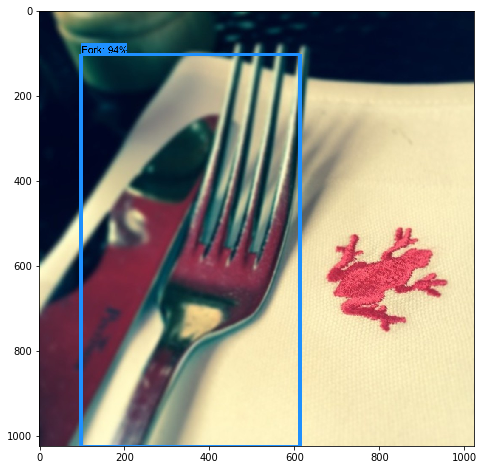

In [41]:
import cv2
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
%matplotlib inline

PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')
NUM_CLASSES = 547
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#.jpg # v4 model
image_path='/root/raw_images_validation/'+decoded_dict[standard_fields.DetectionResultFields.key]+'.jpg'

# image = Image.open(image_path)
# image_np = load_image_into_numpy_array(image)
image_np = cv2.imread(image_path,1)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  decoded_dict['detection_boxes'],
  decoded_dict['detection_classes'],
  decoded_dict['detection_scores'],
  category_index,
  instance_masks=decoded_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
print([category_index[x]['name'] for x in decoded_dict['groundtruth_classes']])
# print(decoded_dict['detection_scores'][0:6])



In [75]:
myarr = np.array([1., 0., np.nan, 3.])

In [77]:
np.nanmean(myarr)

1.3333333333333333